# Analysis of full phenotype prediction models

## Modelling set up

The input Python scripts were written to fit elastic net (linear or log) models
from gene expression data to various phenotypes. They include a multi-stage
cross validation (CV), where the first stage uses "leave one out CV" and then finds
the best model to fit (using 5-fold CV) based on the remaining samples.

All of the results are saved (using `pickle` from Python 3.10.4).

Tiered cross validation:


## Loading data

In [183]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, LeaveOneOut, train_test_split
from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, confusion_matrix, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy import stats
import matplotlib.pyplot as plt
from venn import venn
import pickle
import xlsxwriter
# import xgboost

In [184]:
# IF SET PLOTTING FUNCTIONS SO THAT FIGURES ARE SAVED AT LARGER SIZE

plt.rcParams.update({'lines.markersize': plt.rcParams['lines.markersize']*1.5})
FIXED_SIZE = 18

plt.rc('font', size=FIXED_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FIXED_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FIXED_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FIXED_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FIXED_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FIXED_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=FIXED_SIZE)  # fontsize of the figure title

In [185]:
# load the dataset
zscore_expr_df = pd.read_csv("data/zscore_tpm_table_only_control.csv", index_col = 0, delimiter=',')
expr_df = pd.read_csv("data/tnz_ws2_ril_TPM_table_only_control_2.csv", index_col = 0, delimiter=',')
quart_zscore_expr_df = pd.read_csv("data/zscore_tpm_table_filterd_quadrants.csv", index_col = 0, delimiter=',')
quart_expr_df = pd.read_csv("data//tpm_table_filterd_quadrants.csv", index_col = 0, delimiter=',')
#regs_df = pd.read_csv("data/TPM_z_scored_only_regs.csv", index_col = 0)
pheno_df = pd.read_csv("data/phenotypes.csv", index_col = 0, delimiter=";")
zscore_expr_df = zscore_expr_df.transpose()
display(zscore_expr_df)
#display(regs_df)
display(pheno_df)

,TNZ_1,WS_2,WT_1,WT_10,WT_11,WT_12,WT_13,WT_14,WT_15,WT_16,...,WT_66,WT_68,WT_69,WT_71,WT_73,WT_74,WT_76,WT_77,WT_78,WT_9
AT1G01010,0.081234,-0.591548,-0.893922,0.398727,-0.206021,0.096353,1.283171,-0.062394,0.882525,0.685982,...,-0.432802,0.565032,2.099580,-0.164445,-0.417683,2.950007,1.955953,0.126590,0.731338,-1.370161
AT1G01020,-1.191562,1.299590,0.113999,0.586824,0.375111,-0.514082,0.770308,-0.168284,0.445682,-0.189456,...,-0.316483,-0.739908,-0.048314,0.671509,0.170456,-1.304475,-2.165440,-0.125942,0.876165,0.276312
AT1G01030,3.407318,0.865143,-0.031428,0.104760,-1.064187,-0.882603,0.479277,-0.780462,-0.394596,-0.996093,...,-0.735066,0.263646,1.761713,-0.439992,-0.258408,1.012680,0.286344,-0.315153,2.454002,-0.927999
AT1G01040,1.508933,0.788461,-0.299783,0.785446,-0.953935,-0.399262,0.218715,-0.426393,-0.254565,-0.034505,...,0.101149,0.752287,-1.098632,-0.453524,0.116222,-0.221405,-1.092603,-0.438451,1.484816,-0.649468
AT1G01050,0.101006,0.167611,0.617744,-2.028893,1.605841,-0.345468,-1.042260,0.723141,0.401094,1.009323,...,1.453601,1.802729,-0.406950,1.337957,-0.256905,-0.959552,-0.458184,-0.721677,0.729728,-0.642629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01360,3.697520,0.190524,-0.576631,-0.576631,2.272803,-0.576631,0.080931,-0.576631,-0.576631,0.628899,...,0.080931,-0.576631,-0.576631,-0.576631,-0.576631,-0.576631,2.272803,-0.576631,-0.576631,0.190524
ATMG01370,0.876610,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,3.251779,...,-0.317064,0.718266,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064,-0.317064
ATMG01390,1.453243,-0.081571,0.860247,-0.151335,-0.325745,-1.023388,-0.221099,1.034658,1.732301,0.720719,...,-0.535038,-0.744331,0.930011,0.302133,-1.267563,-1.162917,1.069540,-0.535038,-0.988506,0.023076
ATMG01400,-0.212281,-0.212281,3.733371,-0.212281,-0.212281,-0.212281,-0.212281,-0.212281,-0.212281,-0.212281,...,-0.212281,-0.212281,-0.212281,3.525705,-0.212281,-0.212281,-0.212281,-0.212281,-0.212281,-0.212281


,average_flowering_time
Tnz_1,82.250000
WS_2,65.650000
WT_1,71.500000
WT_10,70.600000
WT_11,70.500000
...,...
WT_74,69.300000
WT_76,64.571429
WT_77,63.285714
WT_78,77.333333


In [186]:
tf_expr_df = pd.read_csv("data//tpm_table_filterd_tf.csv", index_col = 0, delimiter=',')
tf_zscore_expr_df = pd.read_csv("data//zscore_tpm_table_filterd_tf.csv", index_col = 0, delimiter=',')

In [213]:
# load the id to name data frame - useful for plotting with better names!

id_to_name_df = pd.read_csv("data/id_to_name_df.csv", index_col = 0)

display(id_to_name_df)

# # as an example, can I get a list of gene names from ids?
# print(id_to_name_df.loc[["AT1G01020", "AT1G01030", "AT1G01040"], "gene_name"].to_list())

,gene_name,combined_name_id
AT1G01010,NAC001,NAC001 (AT1G01010)
AT1G01020,ARV1,ARV1 (AT1G01020)
AT1G01030,NGA3,NGA3 (AT1G01030)
AT1G01040,DCL1,DCL1 (AT1G01040)
AT1G01050,PPa1,PPa1 (AT1G01050)
...,...,...
AT3G41768,AT3G41768,AT3G41768
AT2G27990,AT2G27990,AT2G27990
AT3G18550,AT3G18550,AT3G18550
AT4G37730,AT4G37730,AT4G37730


In [188]:
# Load the transcription factor family table
# Retreieved from http://planttfdb.gao-lab.org/download/TF_list/Ath_TF_list.txt.gz on 03/03/23

tf_family_df = pd.read_table("data/Ath_TF_list.txt", sep = "\t")

# NOTE that this include DIFFERENT ISOFORMS attached to one gene!
# display(tf_family_df)

tf_family_df = tf_family_df.drop_duplicates(subset='Gene_ID', keep="first")
tf_family_df = tf_family_df.drop("TF_ID", axis =1).set_index("Gene_ID")
display(tf_family_df)

,Family
Gene_ID,
AT3G25730,RAV
AT1G68840,RAV
AT1G13260,RAV
AT1G25560,RAV
AT1G50680,RAV
...,...
AT5G56840,MYB_related
AT5G58340,MYB_related
AT5G58900,MYB_related


In [189]:
leaf_enet = pickle.load(
    open("elastic_net_results/flowering_time_tpm_01.sav", "rb")
)

leaf_regs_enet = pickle.load(
    open("elastic_net_results/flowering_time_tpm_quart_07.sav", "rb")  # note that this is l1_ratio = 0.1
)

biomass_enet = pickle.load(
    open("elastic_net_results/flowering_time_zscore_1.sav", "rb")
)

biomass_regs_enet = pickle.load(
    open("elastic_net_results/flowering_time_zscore_quart_01.sav", "rb")
)

tf_zscore_enet = pickle.load(
    open("elastic_net_results/flowering_time_zscore_tf_01.sav", "rb")
)

tf_normal_enet = pickle.load(
    open("elastic_net_results/flowering_time_tpm_tf_01.sav", "rb")
)

leaf_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_tpm.sav", "rb")
)

leaf_regs_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_tpm_quart.sav", "rb")
)

biomass_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_zscore.sav", "rb")
)

biomass_regs_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_zscore_quart.sav", "rb")
)

tf_zscore_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_zscore_tf.sav", "rb")
)

tf_normal_enet_varying = pickle.load(
    open("elastic_net_results\\all_flowering_time_tpm_tf.sav", "rb")
)



c:\Users\carli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator ElasticNetCV from version 1.1.3 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plots: performance of models

none        | 0 <br>
condition 2 | 1 <br>
condition 3 | 2 <br>
sample    2 | 3 <br>
sample    3 | 4 <br>
C2 + S2     | 5 <br>
C2 + S3     | 6 <br>
C3 + S2     | 7 <br>
C3 + S3     | 8 <br>

In [206]:
color_df = pd.read_csv("data/color_tpm.csv", index_col = 0)
display(color_df.size)

28775

In [191]:
def compare_across_models(
    models_dict, 
    data_df,
    true_vals,
    colour_by_bolting = False
):

    predicted_pheno_dict = dict.fromkeys(models_dict.keys())

    for key, val in models_dict.items():
        single_input = np.array(data_df[key]).reshape(1, -1)
        predicted_pheno_dict[key] = val.predict(single_input)

    predictions = predicted_pheno_dict.values()
    predictions = np.array(list(predictions)).reshape(-1)

    fig, ax = plt.subplots()
    
    if colour_by_bolting:
        col_map = {0:"#191970", 1:"#006400",2:"#ff0000", 3:"#ffd700",4:"#E65719",5:"#00ff00",6:"#00bfff",7:"#0000ff",8:"#ff1493",9:"#ffe4c4"}  # same as in R code
        colouring = color_df['combi_vect'].map(col_map)
    else:
        colouring = None
        
    #print(colouring)
    
    ax.scatter(true_vals, predictions,s=200)
    #ax.set_facecolor(np.array([colouring]))
    
    straight_line = np.linspace(-10**2, 10**2, num = 2000)
    ax.plot(straight_line, straight_line, "--k")
    
    plt.xlim((min(true_vals) - 5, max(true_vals) + 5))
    plt.ylim((min(predictions) - 5, max(predictions) + 5))
    
    ax.text(0.7, 0.05, 
            "RMSE: {0:.2f}".format(
                mean_squared_error(true_vals, predictions, squared = False)
            ),
            transform=ax.transAxes, fontsize = 18)
    ax.text(0.7, 0.15, 
            "$R^2$: {0:.2f}".format(r2_score(true_vals, predictions)),
            transform=ax.transAxes, fontsize = 18)
       
    return fig, ax#, true_vals,predictions

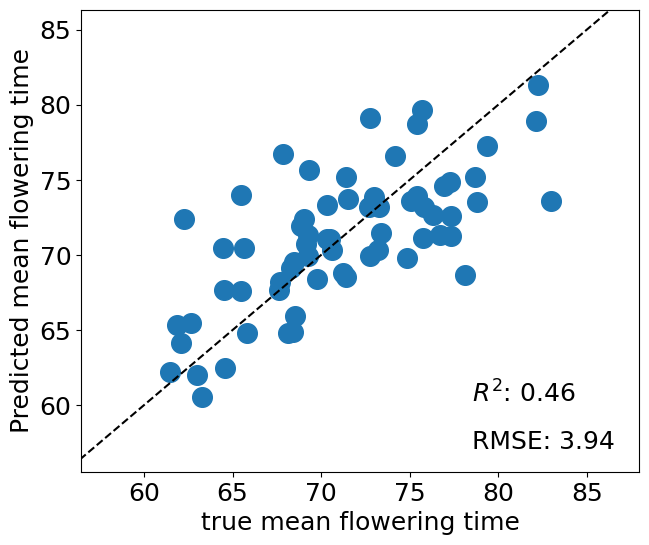

In [192]:
fig_leaf, ax_leaf = compare_across_models(
    leaf_enet,
    expr_df,
    np.array(pheno_df["average_flowering_time"])
    )

#true_vals_list = true_vals.tolist()
#predict_vals_list = predict_vals.tolist()
#print(true_vals_list.index(0))
#print(predict_vals_list[27]) 

#print(expr_df.keys()[27])
   
ax_leaf.set_xlabel("true mean flowering time")
ax_leaf.set_ylabel("Predicted mean flowering time")
ax_leaf.set_title("")
fig_leaf.set_size_inches(6*1.2, 5*1.2)
fig_leaf.savefig("plots/performance/leaf_perf_no_outlier.svg")

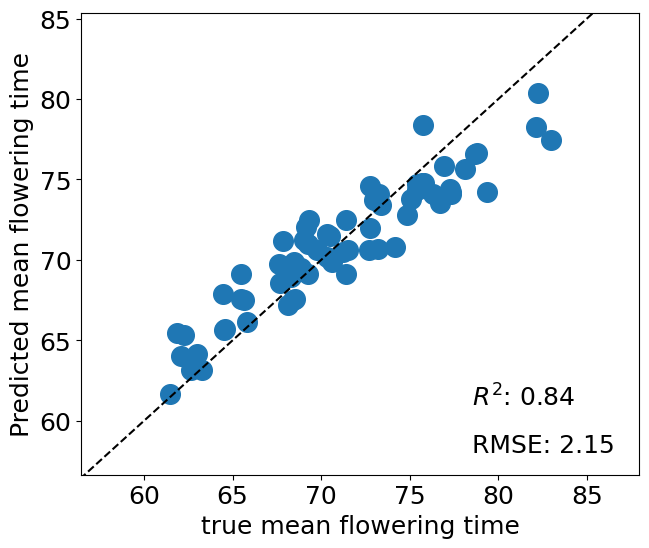

In [193]:
fig_biomass, ax_biomass = compare_across_models(
    biomass_enet,
    zscore_expr_df,
    np.array(pheno_df["average_flowering_time"])
)


ax_biomass.set_xlabel("true mean flowering time")
ax_biomass.set_ylabel("Predicted mean flowering time")
ax_biomass.set_title("")
fig_biomass.set_size_inches(6*1.2, 5*1.2)
fig_biomass.savefig("plots/performance/biomass_perf.svg")

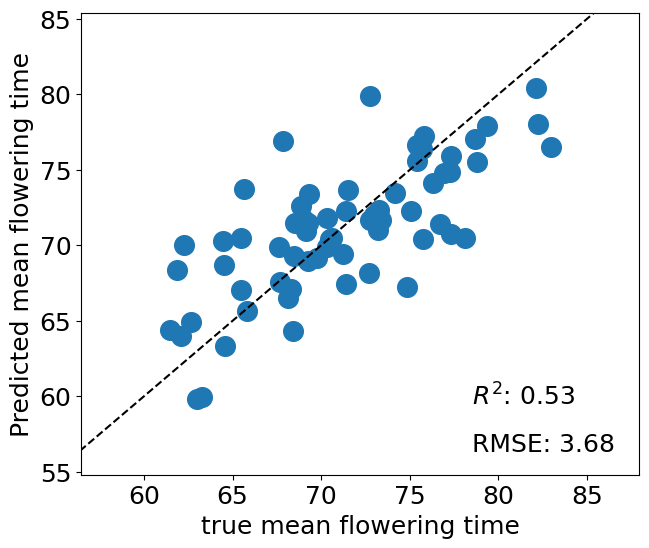

In [194]:
fig_leaf_reg, ax_leaf_reg = compare_across_models(
    leaf_regs_enet,
    quart_expr_df,
    np.array(pheno_df["average_flowering_time"])
)


ax_leaf_reg.set_xlabel("true mean flowering time")
ax_leaf_reg.set_ylabel("Predicted mean flowering time")
ax_leaf_reg.set_title("")
fig_leaf_reg.set_size_inches(6*1.2, 5*1.2)
fig_leaf_reg.savefig("plots/performance/leaf_regs_perf.svg")

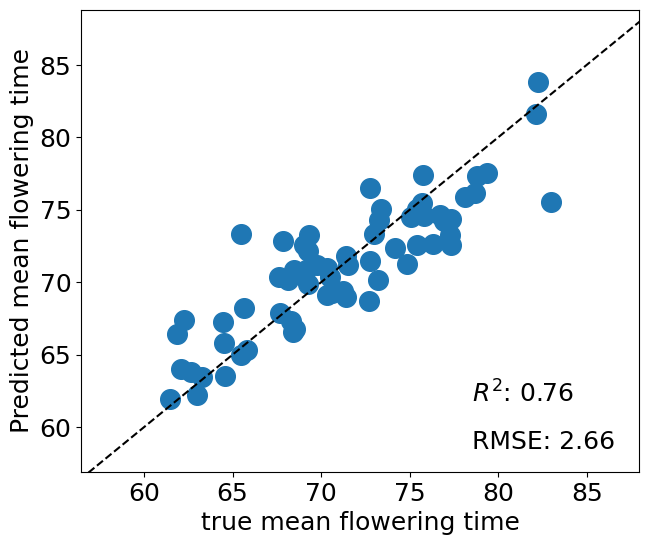

In [195]:
#quart zscore enet
fig_tf_normal, ax_tf_normal = compare_across_models(
    biomass_regs_enet,
    quart_zscore_expr_df,
    np.array(pheno_df["average_flowering_time"])
)


ax_tf_normal.set_xlabel("true mean flowering time")
ax_tf_normal.set_ylabel("Predicted mean flowering time")
ax_tf_normal.set_title("")
fig_tf_normal.set_size_inches(6*1.2, 5*1.2)
fig_tf_normal.savefig("plots/performance/tf_normals_perf.svg")

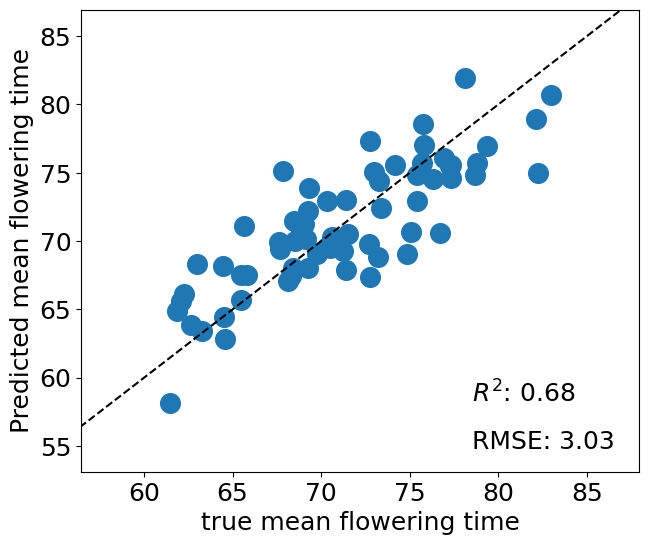

In [196]:
#TF normal
fig_tf_normal, ax_tf_normal = compare_across_models(
    tf_normal_enet, tf_expr_df,
    np.array(pheno_df["average_flowering_time"])
)


ax_tf_normal.set_xlabel("true mean flowering time")
ax_tf_normal.set_ylabel("Predicted mean flowering time")
ax_tf_normal.set_title("")
fig_tf_normal.set_size_inches(6*1.2, 5*1.2)
fig_tf_normal.savefig("plots/performance/biomass_regs_perf.svg")

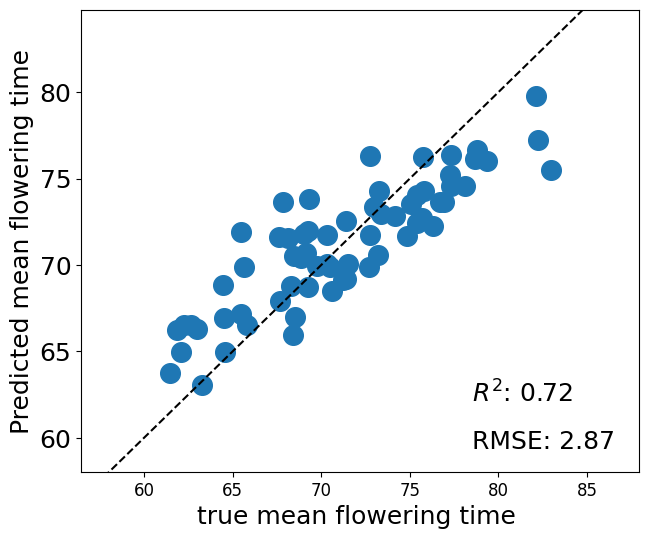

In [207]:
# TF zscore
fig_tf_zscore, ax_tf_zscore = compare_across_models(
    tf_zscore_enet,
    tf_zscore_expr_df,
    np.array(pheno_df["average_flowering_time"])
)


ax_tf_zscore.set_xlabel("true mean flowering time ")
ax_tf_zscore.set_ylabel("Predicted mean flowering time")
ax_tf_zscore.set_title("")
fig_tf_zscore.set_size_inches(6*1.2, 5*1.2)
fig_tf_zscore.savefig("plots/performance/tf_zscores_perf.svg")

## Plots: distribution of coefficients used within models

In [198]:
def plot_violin_of_coefs(
    violin_input_df,
    plot_first_last_num = 10,
    gene_name_df = id_to_name_df
):
    """Takes a data frame of coefficients and makes violin plots showing their distirbutions.
    
    By default only plots the first and last 10 of these. Set plot_first_last_num = NULL to change this.
    """
    
    # following this guide: https://matplotlib.org/stable/gallery/statistics/customized_violin.html
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value

    fig = plt.figure(figsize = (6.4, 4.8), dpi = 90)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

    # check whether there are enough cols to actually truncate them
    num_cols = violin_input_df.shape[1]
    if plot_first_last_num*2 >= num_cols:
        print("Cannot truncate violin plot columns")
        print(f"{plot_first_last_num*2} >= {num_cols}")
        plot_first_last_num = None
    
    # trim to first and last cols if required
    if plot_first_last_num is not None:
        cols_to_plot = list(range(0, plot_first_last_num)) + \
                       list(range(num_cols - plot_first_last_num, num_cols))
        violin_input_df = violin_input_df.iloc[:, cols_to_plot].apply(pd.to_numeric)

    # cast into a list of lists for violin plotting
    violin_input_lists = violin_input_df.to_numpy().transpose().tolist()
        
    # customise violin plots
    parts = ax.violinplot(
        violin_input_lists,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    # overlay box plot ===>
    quartile1, medians, quartile3 = np.percentile(violin_input_lists,
                                                  [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violin_input_lists, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    # <===
    
    plt.axhline(y = 0, linestyle = "--", color='k')
    ax.set_ylabel("Coefficients of gene expression")
    
    # add gene names to the plot - if required
    if gene_name_df is not None:
        ax.set_xticks(np.arange(1, violin_input_df.shape[1] + 1))
        ordered_gene_ids = list(violin_input_df.columns)
        ordered_gene_names = gene_name_df.loc[ordered_gene_ids, "gene_name"].to_list()
        ax.set_xticklabels(
            ordered_gene_names,
            rotation = 90,
            ha = "center"
        )
    else:
        ax.set_xticks(np.arange(1, violin_input_df.shape[1] + 1))
        ordered_gene_ids = list(violin_input_df.columns)
        ax.set_xticklabels(
            ordered_gene_ids,
            rotation = 90,
            ha = "center"
        )
        
        # # this removes gene names entirely - not what i want
#     else:
#         ax.tick_params(
#             axis='x',          
#             which='both',
#             bottom=False,
#             top=False,
#             labelbottom=False
#         )
    
    return fig, ax

In [199]:
def make_coef_df(
    enet_dict,
    data_frame
):
    # create a data frame of coefficient values
    list_of_coef_dicts = [
        dict(zip(data_frame.index, mdl.coef_)) for mdl in enet_dict.values()
    ]
    coef_df = pd.DataFrame.from_dict(list_of_coef_dicts, orient='columns')
    coef_df.index = data_frame.columns
    
    return coef_df

In [200]:
# summary function

def make_summary_of_coefs(
    enet_dict,
    data_frame,
    violin_num = 10,
    gene_name_df = id_to_name_df
):
    
    coef_df = make_coef_df(enet_dict, data_frame)

    # find number of times a gene has non zero coefficent 
    non_zero_counts = coef_df.apply(
        np.count_nonzero,
        raw = True  # passes an np.array rather than pd.series
    )
   
    non_zero_counts_wout0 = non_zero_counts[non_zero_counts > 0] 
    
    # also filter the coef_df to include only coefficients which are used in any model
    coef_df = coef_df.loc[:, non_zero_counts_wout0.index]    
    
    counts, bins = np.histogram(non_zero_counts_wout0,
                                bins = np.max(non_zero_counts_wout0))

    try:    
        fig_hist = plt.figure(figsize = (6.4, 4.8), dpi = 90)
    
        ax_hist = fig_hist.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
    except ValueError:
        pass
    ax_hist.hist(bins[:-1], bins, weights=counts)
    ax_hist.set_xlabel("Number of models using gene (excluding 0)")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title("Distribution of genes which occur as predictors in models")
        
    # prepare data for violin plot
    
    # find the gene names of genes used in every model
    gname_list = list(non_zero_counts.index) 
    max_used_genes_indices = np.where(non_zero_counts == coef_df.shape[0])[0]
    max_used_gnames = [gname_list[i] for i in max_used_genes_indices]
    max_used_genes_df = coef_df[max_used_gnames]
    
    # now find an ordering of the genes by median :)
    median_coefs = max_used_genes_df.apply(
        np.median,
        raw = True
    )
    sort_output = np.argsort(median_coefs)
    sorted_coef_df = max_used_genes_df.iloc[:, sort_output]
    sorted_coef_df = sorted_coef_df.apply(pd.to_numeric)
    
    # make violin plot
    always_subset_fig, always_subset_ax = plot_violin_of_coefs(
        sorted_coef_df,
        plot_first_last_num = violin_num,
        gene_name_df = gene_name_df
    )
    always_subset_ax.set_title("Distributions of coefficients of always-used genes")
       
    return  [fig_hist, ax_hist],[always_subset_fig, always_subset_ax], coef_df, non_zero_counts_wout0

### Also save an xlsx table with summary of coefficients used in all models

In [201]:
def add_summary_stats(df_in):
    # Adds the number of non-zero variables, mean, median,
    # min, and max of each column as new rows of the dataframe
    
    new_df = pd.DataFrame(
        columns=df_in.columns,
        index = ["non-zero", "mean", "median", "min", "max"]
    )
    
    new_df.loc["non-zero"] = df_in.apply(np.count_nonzero, raw = True)
    new_df.loc["mean"] = df_in.apply(np.mean, raw = True)
    new_df.loc["median"] = df_in.apply(np.median, raw = True)
    new_df.loc["min"] = df_in.apply(np.min, raw = True)
    new_df.loc["max"] = df_in.apply(np.max, raw = True)
    
    return pd.concat([new_df, df_in])

## Truncated violins

In [202]:
# RESET XTICKLABEL SIZE FOR THE VIOLIN PLOTS
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels

Cannot truncate violin plot columns
20 >= 9


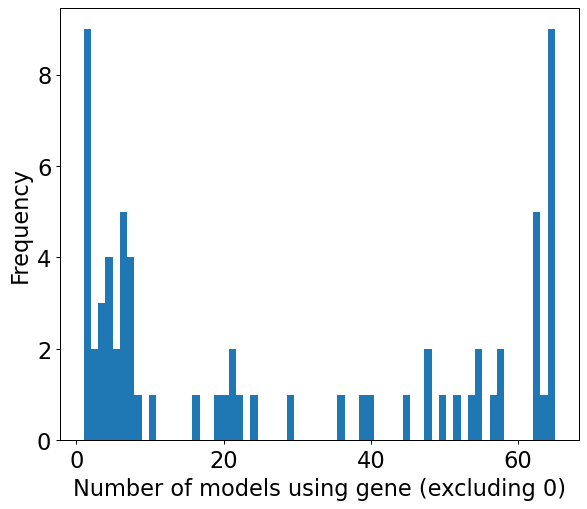

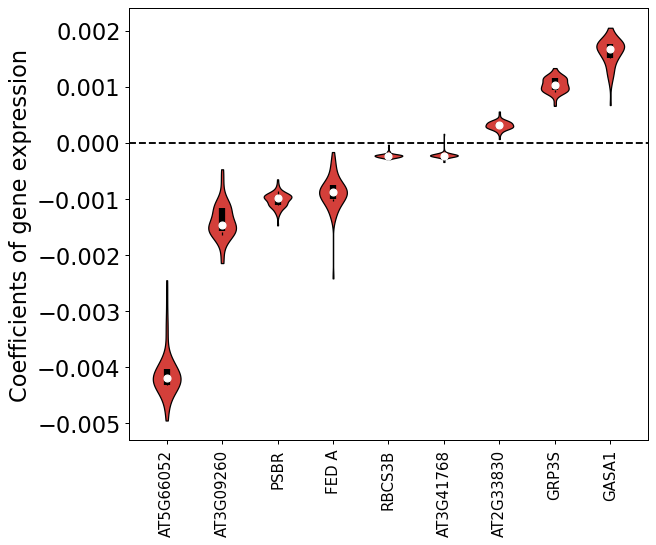

In [203]:
[fig_leaf, ax_leaf], [fig_leaf2, ax_leaf2], leaf_coef_df, leaf_non_zero = make_summary_of_coefs(leaf_enet, expr_df, gene_name_df=id_to_name_df)

ax_leaf.set_title("")
ax_leaf.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_leaf.set_size_inches(6*1.2, 5*1.2)
fig_leaf.savefig("plots/hist/leaf_hist.svg")

ax_leaf2.set_title("")
fig_leaf2.set_size_inches(6*1.2, 5*1.2)
fig_leaf2.savefig("plots/main_violins/leaf_violin.svg", bbox_inches = "tight")

# also save the coefficient data frame - plus summary stats
add_summary_stats(leaf_coef_df).to_excel("gene_regulator_lists/leaf_coefs.xlsx", engine = "xlsxwriter")

Cannot truncate violin plot columns
20 >= 12


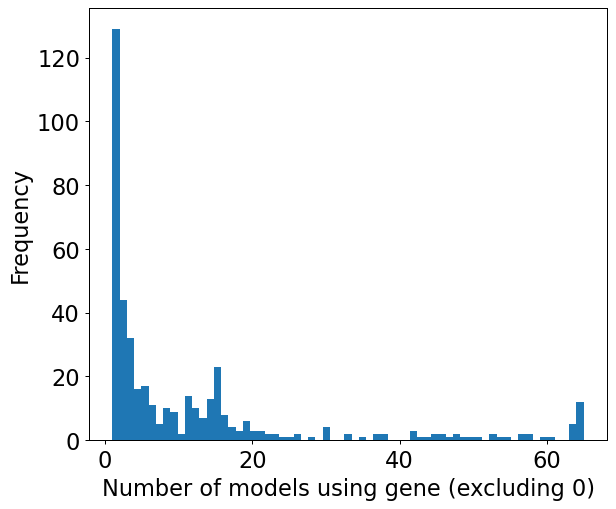

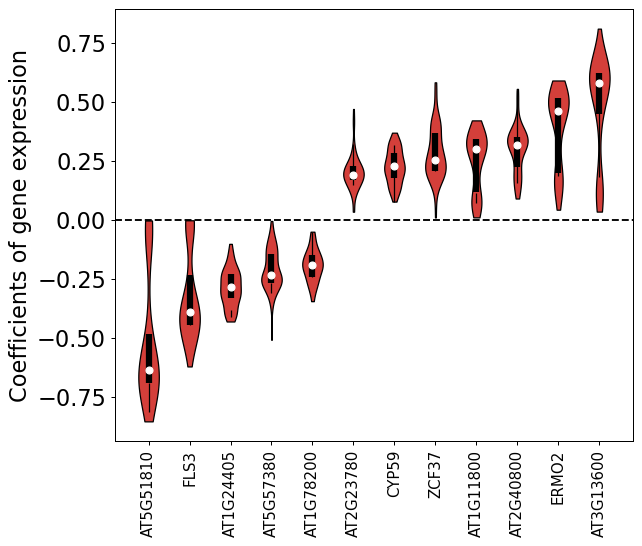

In [204]:
[[fig_biomass, ax_biomass],
 [fig_biomass2, ax_biomass2],
 biomass_coef_df,
 biomass_non_zero] = make_summary_of_coefs(biomass_enet, zscore_expr_df, violin_num=10, gene_name_df=id_to_name_df)

ax_biomass.set_title("")
ax_biomass.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_biomass.set_size_inches(6*1.2, 5*1.2)
fig_biomass.savefig("plots/hist/biomass_hist.svg")

ax_biomass2.set_title("")
fig_biomass2.set_size_inches(6*1.2, 5*1.2)
fig_biomass2.savefig("plots/main_violins/biomass_violin.svg", bbox_inches = "tight")


# also save the coefficient data frame - plus summary stats
add_summary_stats(biomass_coef_df).to_excel("gene_regulator_lists/biomass_coefs.xlsx", engine = "xlsxwriter")

In [205]:
# make a manually updated id to name data frame - accounting for the IDs in violin plots

# 1) make a copy of id_to_name_df
# 2) update the relevant entries within this based on the new df

id_to_name_adjusted = id_to_name_df

manually_df = pd.read_csv("data/manually_updated_names.csv", 
                          index_col = 0,
                          dtype = {"new_name": str})
manually_df.loc[pd.isnull(manually_df.new_name), 'new_name'] = manually_df.index[pd.isnull(manually_df.new_name)]

id_to_name_adjusted = id_to_name_adjusted.replace(
    manually_df.loc[:, "new_name"].to_dict()
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/manually_updated_names.csv'

Cannot truncate violin plot columns
20 >= 9


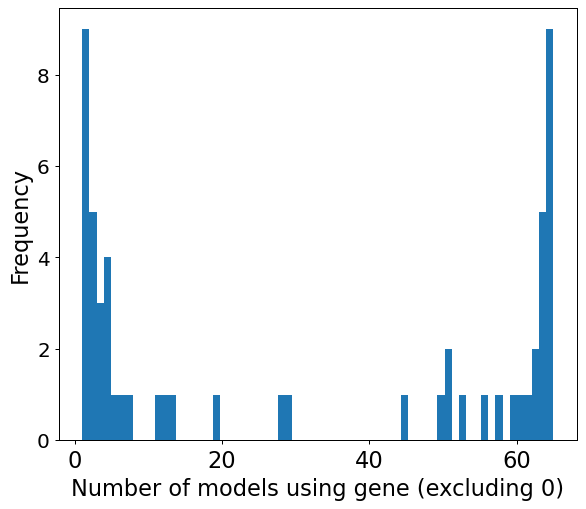

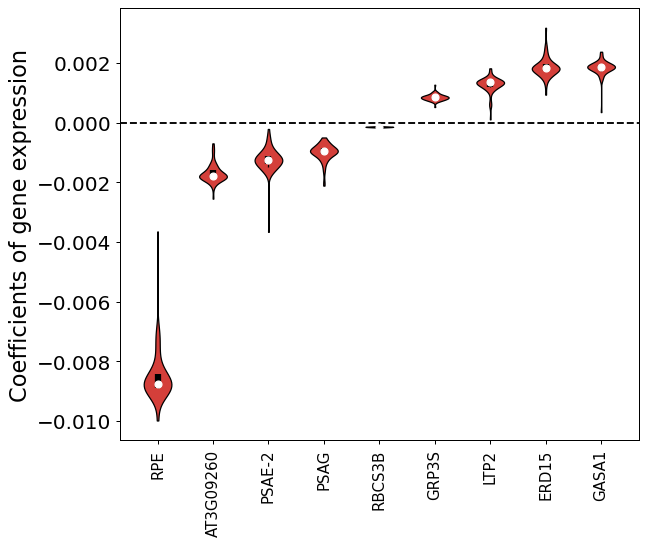

In [ ]:
[[fig_leaf_regs, ax_leaf_regs],
 [fig_leaf_regs2, ax_leaf_regs2],
 leaf_regs_coef_df,
 leaf_regs_non_zero] = make_summary_of_coefs(leaf_regs_enet, quart_expr_df, violin_num=10, gene_name_df=id_to_name_df)

ax_leaf_regs.set_title("")
ax_leaf_regs.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_leaf_regs.set_size_inches(6*1.2, 5*1.2)
fig_leaf_regs.savefig("plots/hist/leaf_regs_hist.svg")

ax_leaf_regs2.set_title("")
fig_leaf_regs2.set_size_inches(6*1.2, 5*1.2)
fig_leaf_regs2.savefig("plots/main_violins/leaf_regs_violin.svg", bbox_inches = "tight")

# also save the coefficient data frame - plus summary stats
add_summary_stats(leaf_regs_coef_df).to_excel("gene_regulator_lists/leaf_regs_coefs.xlsx", engine = "xlsxwriter")

In [ ]:
# repeat this without the gene names ...
_ = make_summary_of_coefs(leaf_regs_enet, regs_df, violin_num=10, gene_name_df=None)

NameError: name 'regs_df' is not defined

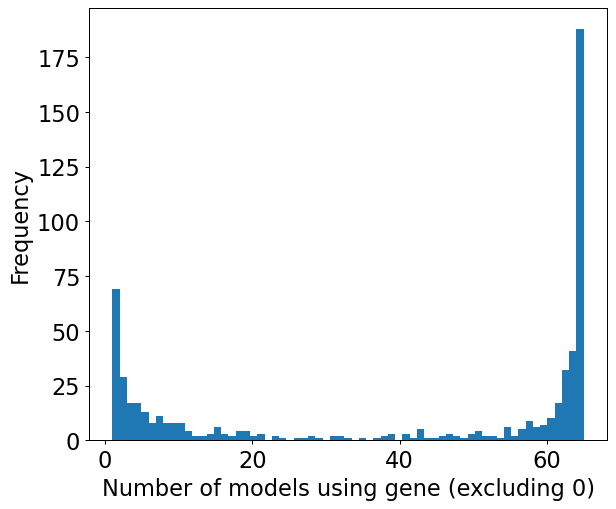

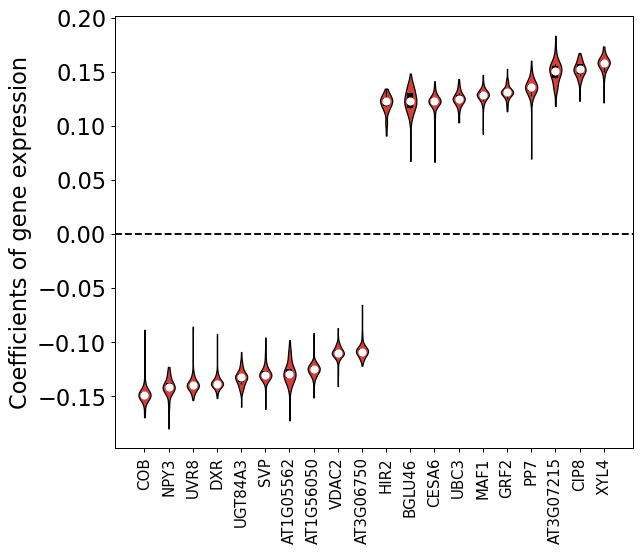

In [214]:
[[fig_biomass_regs, ax_biomass_regs],
 [fig_biomass_regs2, ax_biomass_regs2],
 biomass_regs_coef_df,
 biomass_regs_non_zero] = make_summary_of_coefs(biomass_regs_enet, quart_zscore_expr_df, violin_num=10, gene_name_df=id_to_name_df)

ax_biomass_regs.set_title("")
ax_biomass_regs.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_biomass_regs.set_size_inches(6*1.2, 5*1.2)
fig_biomass_regs.savefig("plots/hist/biomass_regs_hist.svg")

ax_biomass_regs2.set_title("")
fig_biomass_regs2.set_size_inches(6*1.2, 5*1.2)
fig_biomass_regs2.savefig("plots/main_violins/biomass_regs_violin.svg", bbox_inches = "tight")

# also save the coefficient data frame - plus summary stats
add_summary_stats(biomass_regs_coef_df).to_excel("gene_regulator_lists/biomass_regs_coefs.xlsx", engine = "xlsxwriter")

Cannot truncate violin plot columns
20 >= 10


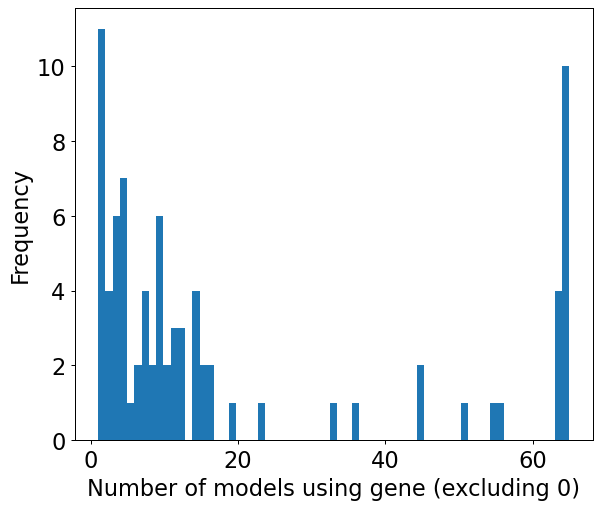

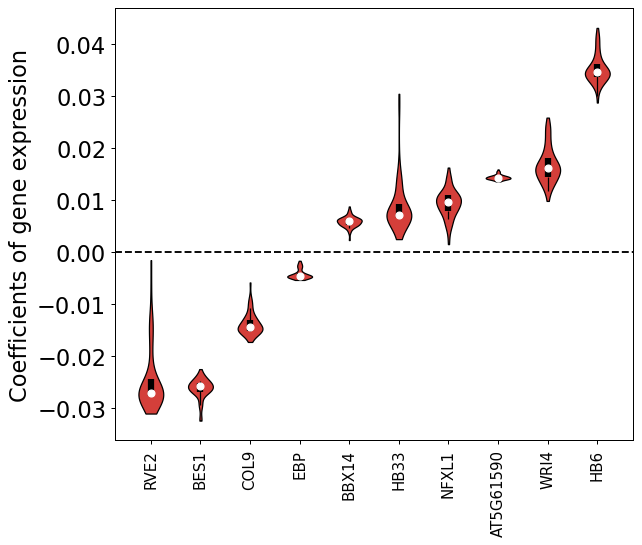

In [215]:
# normal TF
# normal TF
[[fig_tf_normal, ax_tf_normal],
 [fig_tf_normal2, ax_tf_normal2],
 tf_normal_coef_df,
 tf_normal_non_zero] = make_summary_of_coefs(tf_normal_enet, tf_expr_df, violin_num=10, gene_name_df=id_to_name_df)

ax_tf_normal.set_title("")
ax_tf_normal.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_tf_normal.set_size_inches(6*1.2, 5*1.2)
fig_tf_normal.savefig("plots/hist/tf_normal_hist.svg")

ax_tf_normal2.set_title("")
fig_tf_normal2.set_size_inches(6*1.2, 5*1.2)
fig_tf_normal2.savefig("plots/main_violins/tf_normal_violin.svg", bbox_inches = "tight")

# also save the coefficient data frame - plus summary stats
add_summary_stats(tf_normal_coef_df).to_excel("gene_regulator_lists/tf_normal_coefs.xlsx", engine = "xlsxwriter")

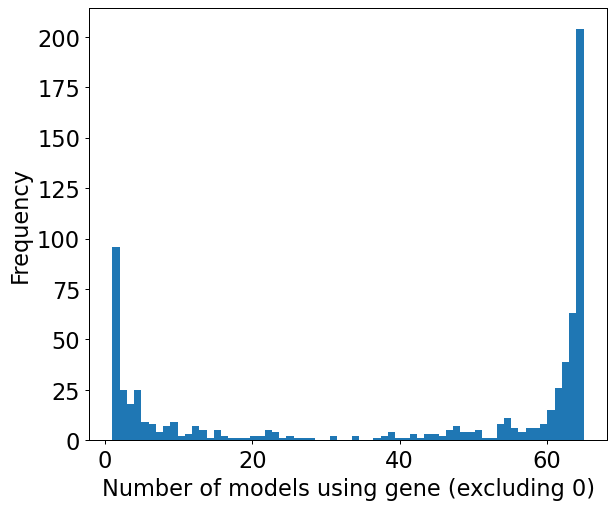

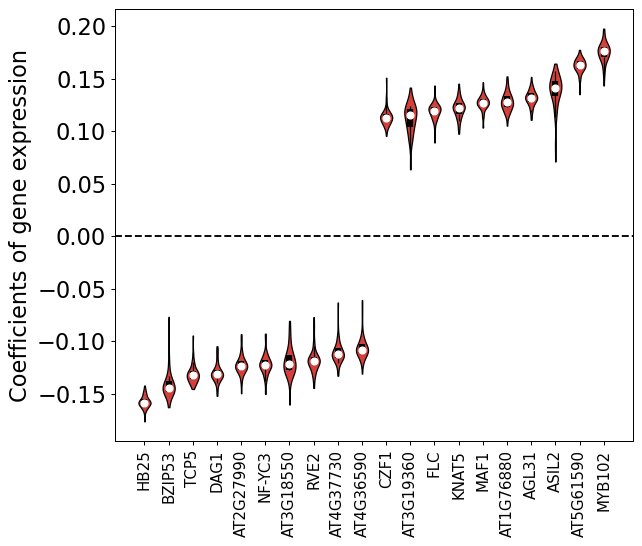

In [216]:
#zscore
[[fig_tf_zscore, ax_tf_zscore],
 [fig_tf_zscore2, ax_tf_zscore2],
 tf_zscore_coef_df,
 tf_zscore_non_zero] = make_summary_of_coefs(tf_zscore_enet, tf_zscore_expr_df, violin_num=10, gene_name_df=id_to_name_df)

ax_tf_zscore.set_title("")
ax_tf_zscore.tick_params(axis = 'x', which = 'major', labelsize = 18) 
fig_tf_zscore.set_size_inches(6*1.2, 5*1.2)
fig_tf_zscore.savefig("plots/hist/tf_zscore_hist.svg")

ax_tf_zscore2.set_title("")
fig_tf_zscore2.set_size_inches(6*1.2, 5*1.2)
fig_tf_zscore2.savefig("plots/main_violins/tf_zscore_violin.svg", bbox_inches = "tight")

# also save the coefficient data frame - plus summary stats
add_summary_stats(tf_zscore_coef_df).to_excel("gene_regulator_lists/tf_zscore_coefs.xlsx", engine = "xlsxwriter")

Cannot truncate violin plot columns
20 >= 9


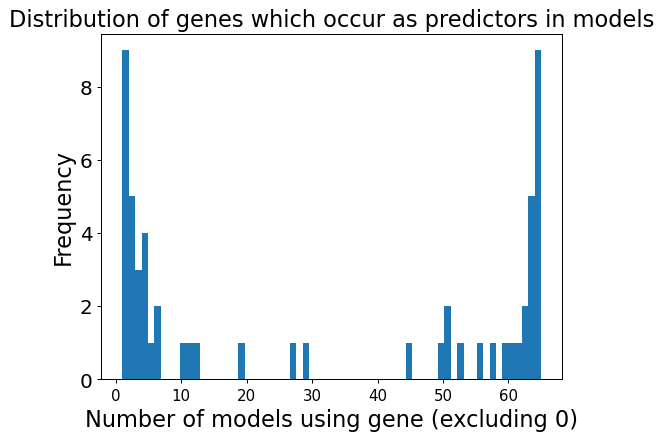

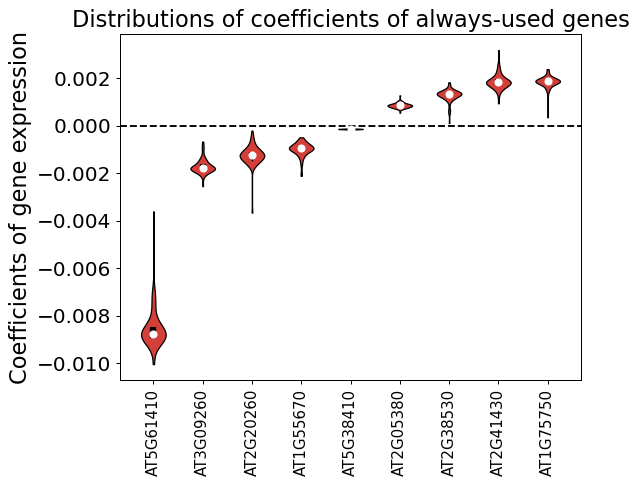

In [ ]:
# repeat this without the gene names ...
_ = make_summary_of_coefs(biomass_regs_enet, quart_zscore_expr_df, violin_num=10, gene_name_df=None)

In [ ]:
# RESET XTICKLABEL SIZE FOR THE VIOLIN PLOTS
plt.rc('xtick', labelsize=FIXED_SIZE)    # reset for normal plots

### Final version - include values from ALL predictors (even if they are not used in all models)

This makes more sense since low-used genes will be close to zero (or = 0) but genes with > 60 values will have non-zero median.

In [ ]:
# RESET XTICKLABEL SIZE
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)

In [ ]:
leaf_regs_simple = return_all_predictors(leaf_regs_enet, quart_expr_df, only_use_maximal_predictors = False)
biomass_regs_simple = return_all_predictors(biomass_regs_enet, quart_zscore_expr_df, only_use_maximal_predictors = False)

leaf_meds = leaf_regs_simple.apply("median")
biomass_meds = biomass_regs_simple.apply("median")

both_medians = pd.DataFrame.from_dict({
    "leaf": leaf_meds,
    "biomass": biomass_meds
}).fillna(0)

# save this comparison of median values between physiology so I can find genes of interest
both_medians.to_excel(
    "gene_regulator_lists/compare_leaf_biomass_medians.xlsx", 
    engine="xlsxwriter"
)

NameError: name 'return_all_predictors' is not defined

leaf      -0.026526
biomass         0.0
colour        black
Name: AT4G01720, dtype: object


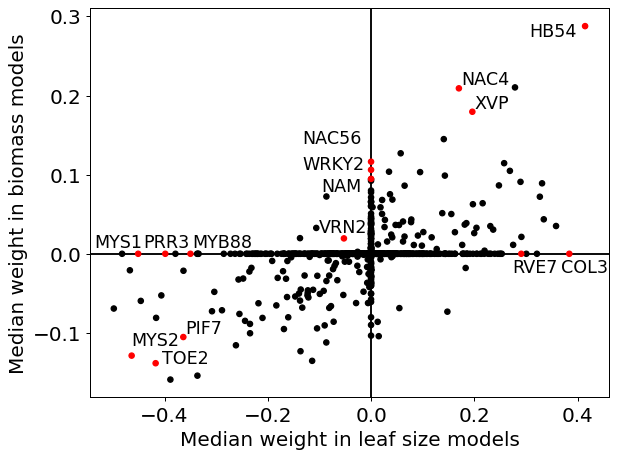

In [ ]:
print(both_medians.loc["AT4G01720", :])

fig_both_medians = plt.figure(figsize = (6.4, 4.8), dpi = 90)
ax_both_medians = fig_both_medians.add_axes([0.1, 0.1, 0.9, 0.9])

ax_both_medians.axhline(y=0, color='k', zorder = 0)
ax_both_medians.axvline(x=0, color='k', zorder = 0)

ax_both_medians.set_xlabel(
    "Median weight in leaf size models",
    size = 16
)
ax_both_medians.set_ylabel(
    "Median weight in biomass models",
    size = 16
)

# add a colour column to highlight specific genes
genes_to_highlight = {
    "AT2G24790": "COL3",
    "AT1G18330": "RVE7",
    "AT2G38300": "MYS1",
    "AT5G60100": "PRR3",
    "AT2G02820": "MYB88",
    "AT3G15510": "NAC56",
    "AT5G56270": "WRKY2",
    "AT1G52880": "NAM",
    "AT1G27045": "HB54",
    "AT1G02220": "XVP",
    "AT5G07680": "NAC4",
    "AT2G40260": "MYS2",
    "AT5G61270": "PIF7",
    "AT5G60120": "TOE2",
    "AT4G16845": "VRN2"
}

cols = {goi: "red" if goi in genes_to_highlight.keys() else "black" 
        for goi in both_medians.index}

both_medians_for_plotting = both_medians
both_medians_for_plotting["colour"] = both_medians_for_plotting.index.map(cols)

# plot the back dots then the red dots

black_dots = both_medians_for_plotting.loc[both_medians_for_plotting["colour"] == "black", :]
red_dots = both_medians_for_plotting.loc[both_medians_for_plotting["colour"] == "red", :]

# draw scatterplot with specific colours
ax_both_medians.scatter(
    x = black_dots["leaf"],
    y = black_dots["biomass"], 
    s=18,
    c = black_dots["colour"]
)

# draw scatterplot with specific colours
ax_both_medians.scatter(
    x = red_dots["leaf"],
    y = red_dots["biomass"], 
    s=18,
    c = red_dots["colour"]
)

# add the annotations
custom_offsets = {
    "AT2G24790": (-7, -15),
    "AT1G18330": (-7, -15),
    "AT2G38300": (-35, 5),
    "AT5G60100": (-17.5, 5),
    "AT2G02820": (1.5, 5),
    "AT3G15510": (-55, 15),
    "AT5G56270": (-55, 0),
    "AT1G52880": (-40, -10),
    "AT1G27045": (-45, -8),
    "AT1G02220": (1.5, 3),
    "AT5G07680": (1.5, 3),
    "AT2G40260": (0, 8),
    "AT5G61270": (1.5, 3),
    "AT5G60120": (5, 0),
    "AT1G07050": (1.5, 3),
    "AT4G16845": (-20, 5)
}

for gene, label in genes_to_highlight.items():
    ax_both_medians.annotate(
        label,
        xy = both_medians_for_plotting.loc[gene, ["leaf", "biomass"]],
        xytext = custom_offsets[gene],
        textcoords='offset points',
        size = 14
    )

fig_both_medians.savefig("plots/between_types/median.svg")

### Venn diagram of biomass / leaf  + positive / negative

In [ ]:
leaf_neg = []
leaf_pos = []
biomass_neg = []
biomass_pos = []

obj = both_medians[["leaf"]]
for i in range(len(obj)):
    if obj.iloc[i].leaf < 0:
        leaf_neg.append(obj.iloc[i].name)
        
obj = both_medians[["leaf"]]
for i in range(len(obj)):
    if obj.iloc[i].leaf > 0:
        leaf_pos.append(obj.iloc[i].name)
        
obj = both_medians[["biomass"]]
for i in range(len(obj)):
    if obj.iloc[i].biomass < 0:
        biomass_neg.append(obj.iloc[i].name)
        
obj = both_medians[["biomass"]]
for i in range(len(obj)):
    if obj.iloc[i].biomass > 0:
        biomass_pos.append(obj.iloc[i].name)

NameError: name 'both_medians' is not defined

In [ ]:
leaf_biomass_pred_venn = venn(
    {"Leaf, Negative": set(leaf_neg),
     "Leaf, Positive": set(leaf_pos),
     "Biomass, Negative": set(biomass_neg),
     "Biomass, Positive": set(biomass_pos)},
     cmap = "viridis"
)

leaf_biomass_pred_venn.get_figure().savefig("plots/between_types/predictor_venn.svg")

ZeroDivisionError: division by zero

***

****************

## Supplemental: outputting lists of l1_ratio and alpha when they can vary

### Information about hyperparam selection

Key hyperparams chosen in during LOOCV: 
- `alpha` - the scaling of the regularisation. This was chosen through the process described in the original enet paper (Zou, Hui, and Trevor Hastie. 2005. “Regularization and Variable Selection via the Elastic Net.” Journal of the Royal Statistical Society. Series B, Statistical Methodology 67 (2): 301–20.).
- `l1_ratio` - the ratio between $l_1$ to $l_2$ normalisation. The possible options which were searched through were: `[.1, .5, .7, .9, .95, .99, 1]`, as the default value suggested by `scikit-learn`.

### Notes:
- The choice of `l1_ratio` prioritised lasso (where `l1_ratio = 1`) but the actual values are near `0.5`. Potentially it would be worth repeating this with more options around this value if the predictions are poor.
- An increased `l1_ratio` tends to harsher variable selection. It might be better to leave this fixed at `0.5` - to avoid biasing other results by varying the number of non-zero coefficients.

**The next sections go through each type of plot at a time**

In [ ]:
def save_varying_l1_alpha(
    enet_dict,
    filename
):
    l1_vals = [mdl.l1_ratio_ for mdl in enet_dict.values()]
    alpha_vals = [mdl.alpha_ for mdl in enet_dict.values()]
    out_df = pd.DataFrame({"l1_ratio": l1_vals, "alpha": alpha_vals},
                          index=enet_dict.keys())
    out_df.to_excel(filename, engine = "xlsxwriter")
    
    return None

In [ ]:
save_varying_l1_alpha(leaf_enet_varying, "hyperparam_lists/leaf_hyperparams.xlsx")
#save_varying_l1_alpha(leaf_regs_enet_varying, "hyperparam_lists/leaf_regs_hyperparams.xlsx")
#save_varying_l1_alpha(biomass_enet_varying, "hyperparam_lists/biomass_hyperparams.xlsx")
#save_varying_l1_alpha(biomass_regs_enet_varying, "hyperparam_lists/biomass_regs_hyperparams.xlsx")

## Supplemental: plots of which hyperparams are selected when they are allowed to change?

These show that different hyperparameters are selected during optimization - depending on which samples are removed during LOOCV. For figures above, l1_ratio was set to the *mode* value it achieved, when allowed to vary. Alpha is still allowed to vary to account for different scaling between datasets when one sample is removed.

In [ ]:
def plot_varying_l1_ratio(
    enet_dict,
    custom_title = "Optimised l1_ratio across all folds (LOOCV)"
):
    fig = plt.figure(figsize = (14, 6), dpi = 90)
    l1_vals = [mdl.l1_ratio_ for mdl in enet_dict.values()]
    plt.bar(list(enet_dict.keys()),
            height = l1_vals)
    plt.title(custom_title)
    plt.xticks(rotation = 90, ha = 'center')
    plt.xlabel("Sample removed")
    
    print(f"Mode l1_ratio is {stats.mode(l1_vals)}")
    
    return fig 

In [ ]:
def plot_varying_alpha(
    enet_dict,
    custom_title = "Optimised alpha across all folds (LOOCV)"
):
    fig = plt.figure(figsize = (14, 6), dpi = 90)
    plt.bar(list(enet_dict.keys()),
            height = [mdl.alpha_ for mdl in enet_dict.values()])
    plt.title(custom_title)
    plt.xticks(rotation = 90, ha = 'center')
    plt.xlabel("Sample removed")
    return fig 

In [ ]:
# create a list of number of non-zero coeffecients for each model
def plot_varying_non_zero(
    enet_dict,
    custom_title = "Number of non-zero coefficients for the optimal models"
):
    num_non_zero = [sum((eg_model.coef_ != 0)) for eg_model in enet_dict.values()]

    fig = plt.figure(figsize = (14, 6), dpi = 90)
    plt.bar(list(enet_dict.keys()),
            height = num_non_zero)
    plt.title(custom_title)
    plt.xlabel("Sample removed")
    plt.xticks(rotation = 90, ha = 'center')
    return fig

### Hyperparam plots for leaf size with all genes

In [ ]:
# RESET XTICKLABEL SIZE FOR THE VIOLIN PLOTS
plt.rc('xtick', labelsize=12)    # reset for normal plots

Mode l1_ratio is ModeResult(mode=array([0.1]), count=array([51]))


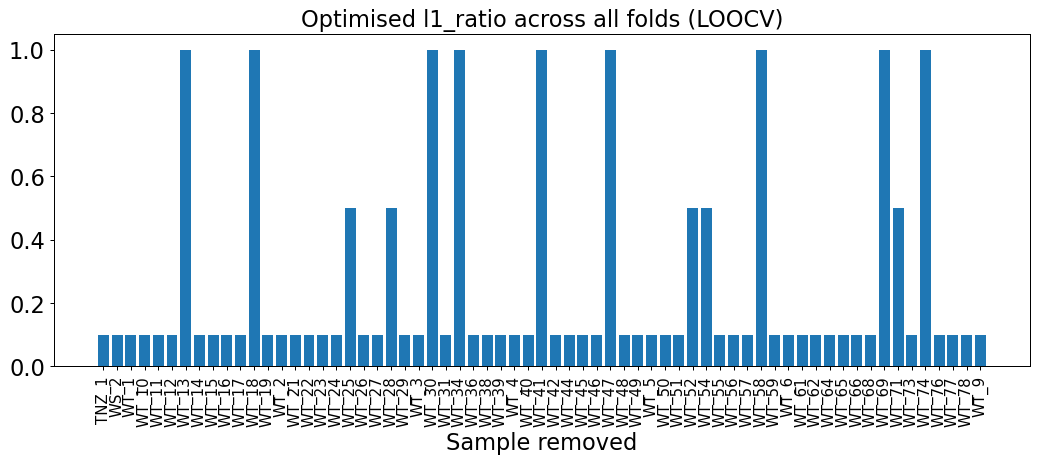

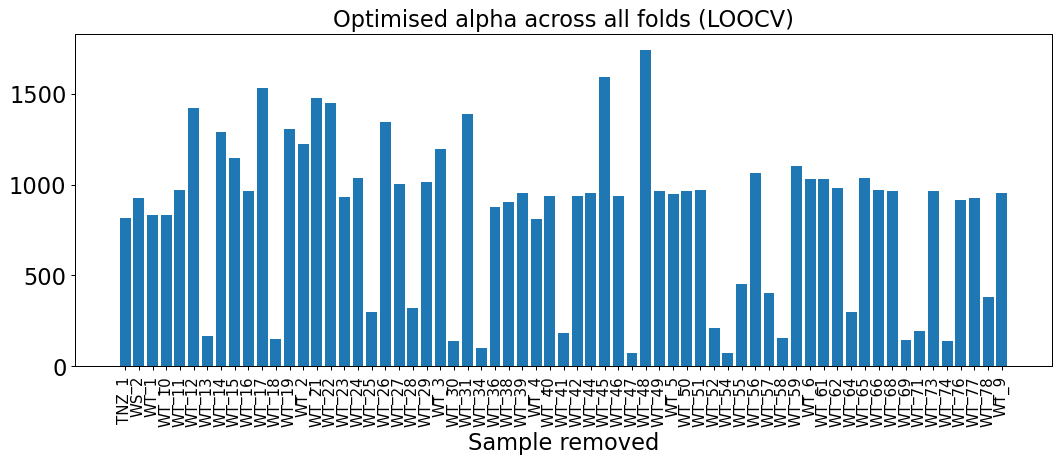

In [ ]:
fig1 = plot_varying_l1_ratio(leaf_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/leaf.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(leaf_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/leaf.svg", bbox_inches="tight")

Mode l1_ratio is ModeResult(mode=array([0.7]), count=array([33]))


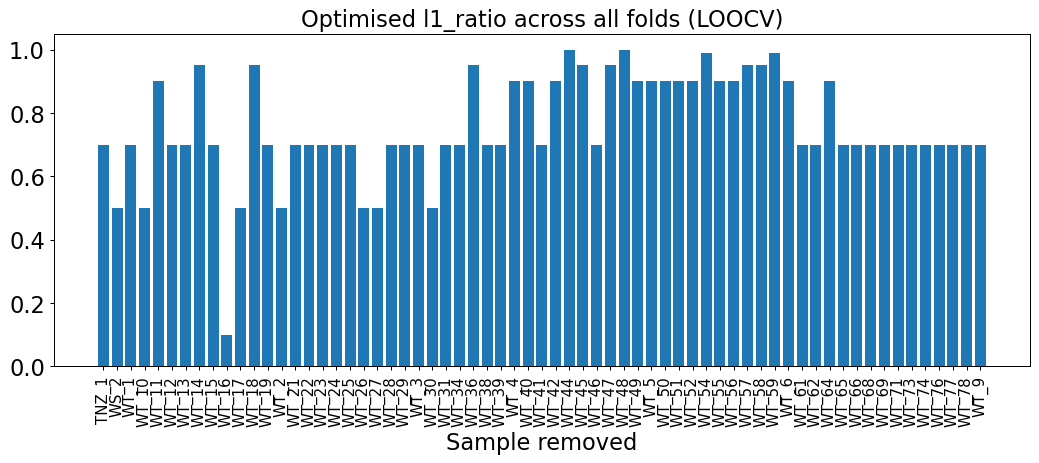

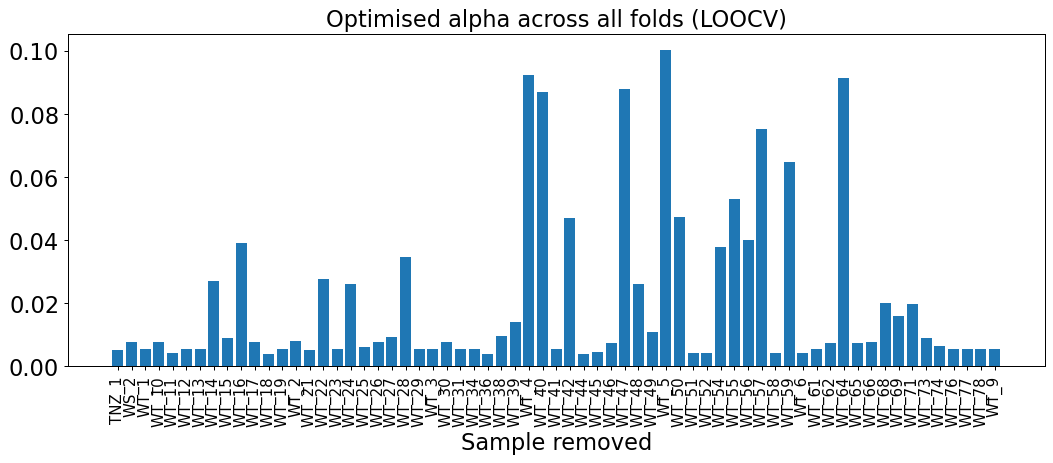

In [ ]:
fig1 = plot_varying_l1_ratio(biomass_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/biomass.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(biomass_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/biomass.svg", bbox_inches="tight")

Mode l1_ratio is ModeResult(mode=array([1.]), count=array([60]))


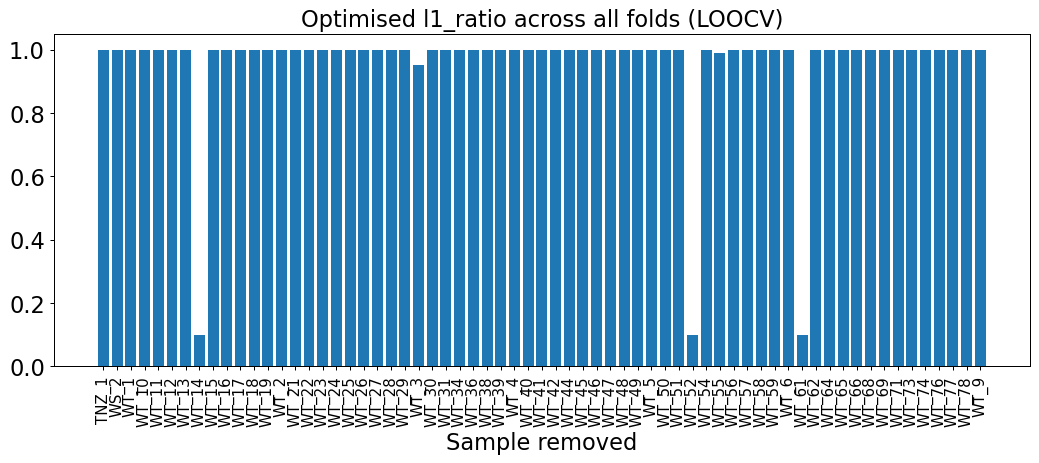

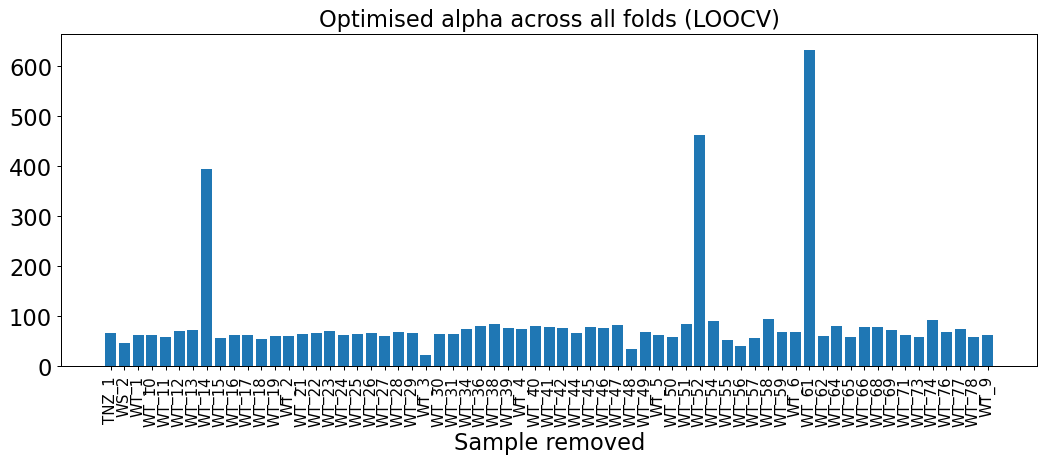

In [ ]:
fig1 = plot_varying_l1_ratio(leaf_regs_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/leaf_regs.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(leaf_regs_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/leaf_regs.svg", bbox_inches="tight")

Mode l1_ratio is ModeResult(mode=array([0.1]), count=array([64]))


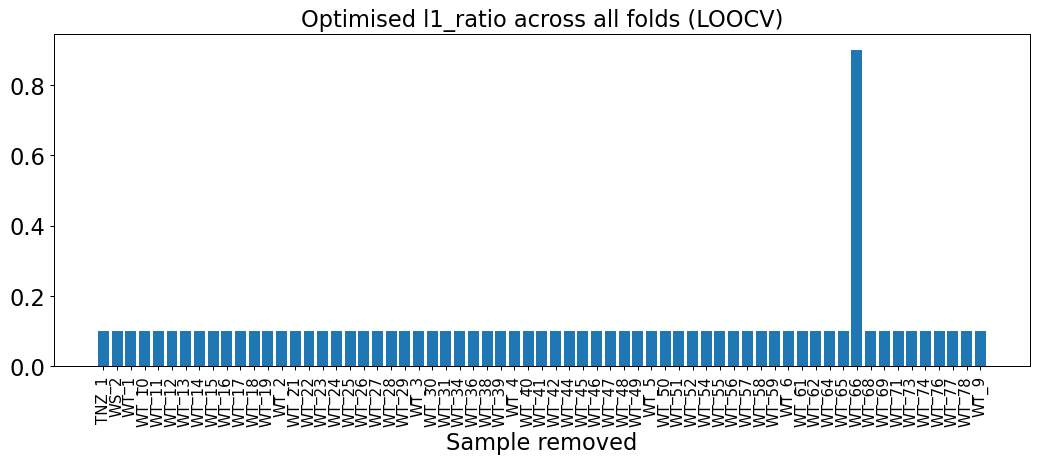

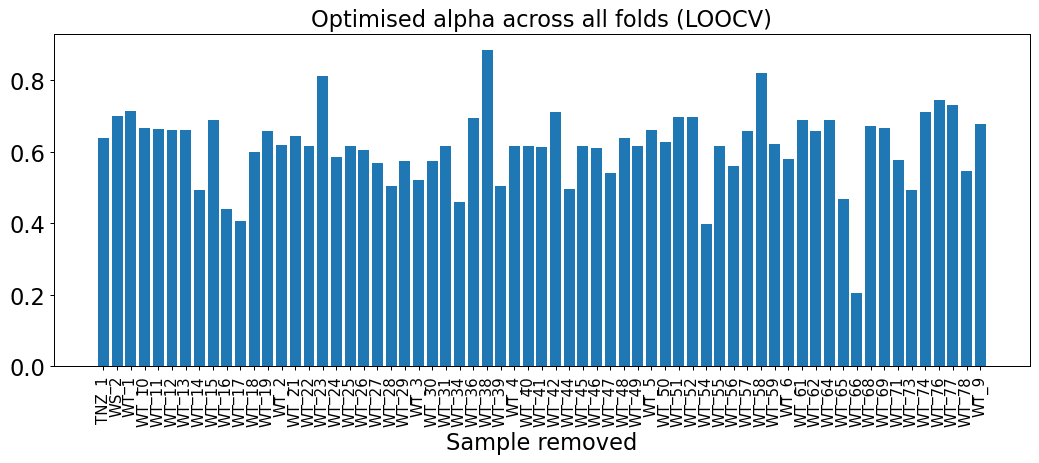

In [ ]:
fig1 = plot_varying_l1_ratio(biomass_regs_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/biomass_regs.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(biomass_regs_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/biomass_regs.svg", bbox_inches="tight")

Mode l1_ratio is ModeResult(mode=array([0.1]), count=array([62]))


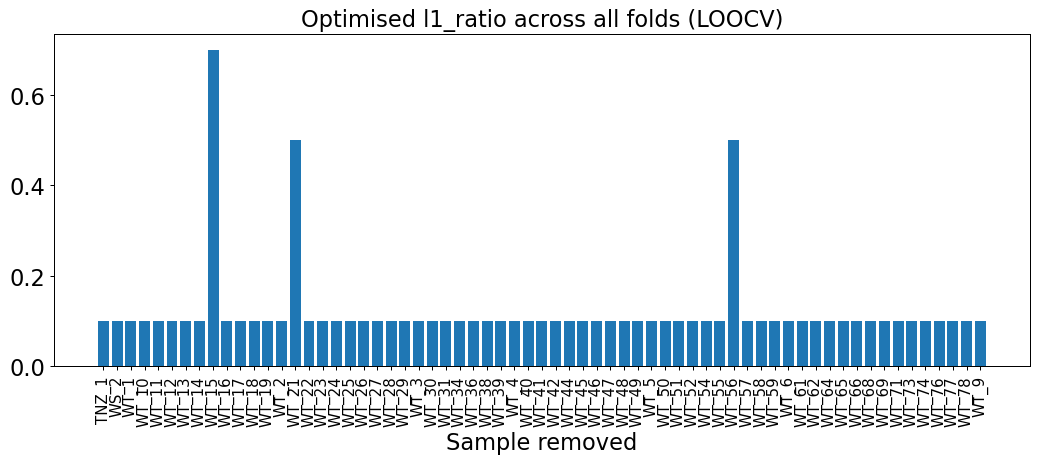

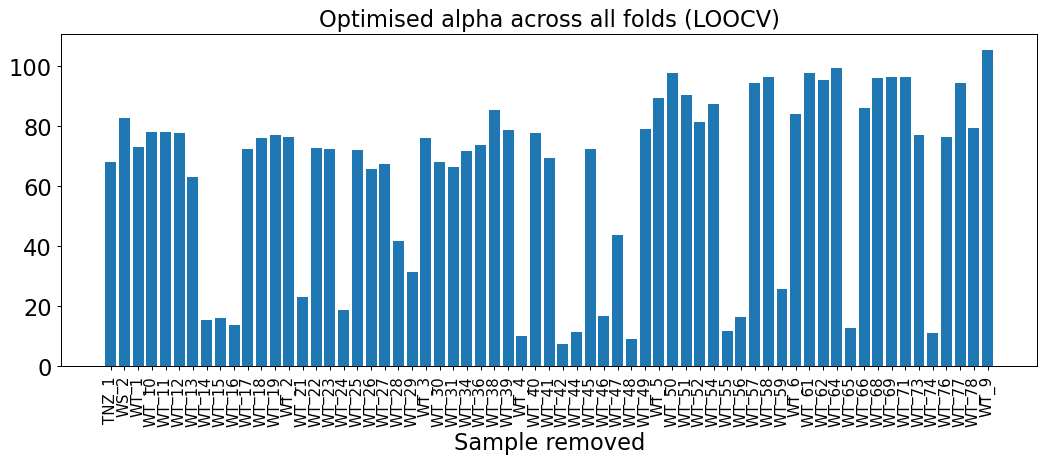

In [ ]:
fig1 = plot_varying_l1_ratio(tf_normal_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/tf_normal_enet_varying.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(tf_normal_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/tf_normal_enet_varying.svg", bbox_inches="tight")

Mode l1_ratio is ModeResult(mode=array([0.1]), count=array([63]))


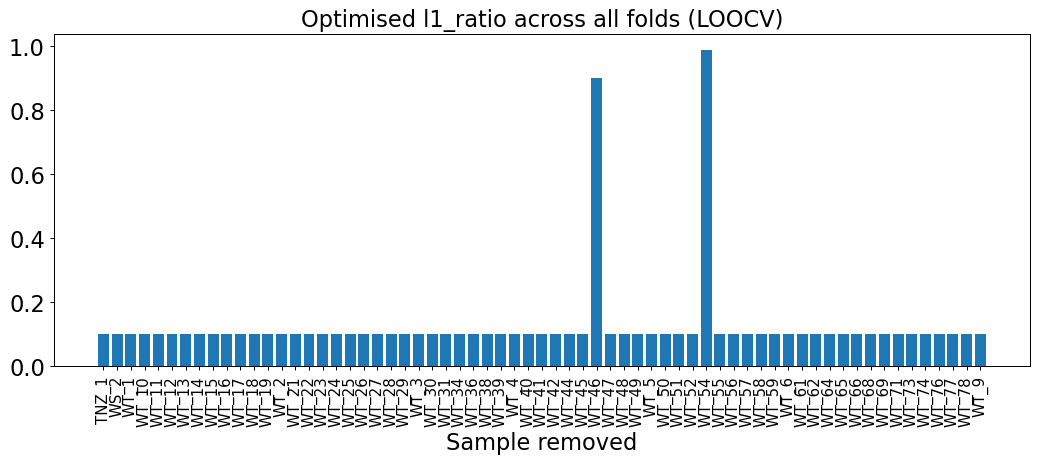

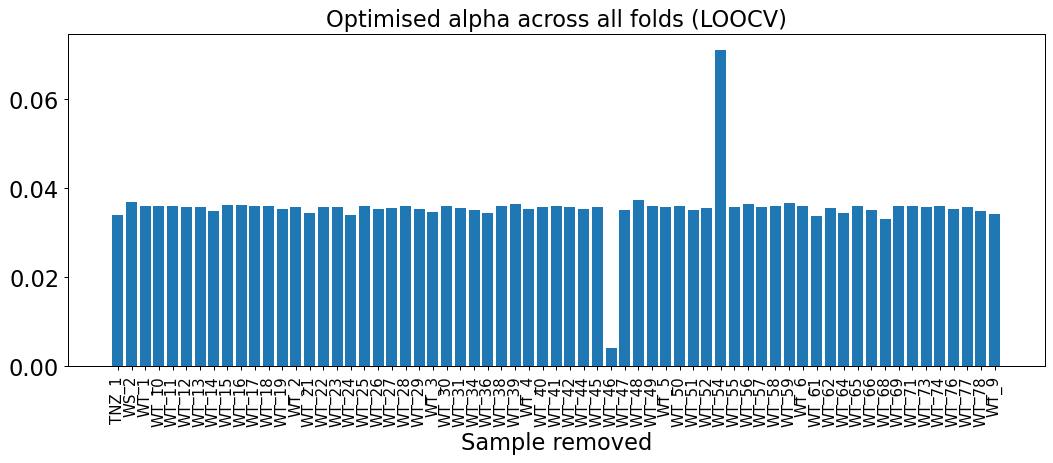

In [ ]:
fig1 = plot_varying_l1_ratio(tf_zscore_enet_varying)
fig1.set_size_inches(14, 4.8)
fig1.savefig("plots/l1_ratio/tf_zscore_enet_varying.svg", bbox_inches="tight")

fig2 = plot_varying_alpha(tf_zscore_enet_varying)
fig2.set_size_inches(14, 4.8)
fig2.savefig("plots/alpha/tf_zscore_enet_varying.svg", bbox_inches="tight")